# **Neural Machine Translation with Teacher Forcing using Tensorflow**

# **Overview :**

Neural Machine Translation model with teacher forcing using Tensorflow to translate text from **English to Javanese**. The initial code based on natural language processing project by Balamurugan1603 (https://github.com/balamurugan1603/English-to-Italian-Neural-Machine-Translator).

Modified for information extraction to be able searching with google. By group 4:
1. Muhammad Fahli Saputra (210535614835)
2. Naufal Rizaldi Gunawan (210535614872)
3. Manuel Tanbica Graciello (210535614820)
4. Muhammad Rayhan Ardhinar (210535614848)

# **Dependencies :**

In [1]:
# Importing dependancies

import os
import warnings
import pickle
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from IPython.display import display
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense
from tensorflow.keras.models import Model, save_model
import yake
from googlesearch import search
import bs4 
import requests

2023-12-03 10:06:00.666165: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 10:06:00.783221: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 10:06:01.277366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 10:06:01.277452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 10:06:01.382072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# **Configuration :**

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

# **Loading data and basic preprocessing :**

In [3]:
# Loads data
data = pd.read_csv("new_corpus.txt", sep="\t")

In [4]:
# Sets column names
data.columns = ["english", "jawa"]

In [5]:
display(data.head())
display(data.info())

,english,jawa
0,No,Mboten
1,In,Ing
2,In,Ning
3,Yes,Enggeh
4,Eat,Mangan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  1014 non-null   object
 1   jawa     1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


None

In [6]:
# Drops null values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  1014 non-null   object
 1   jawa     1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [7]:
# Adds 'sos' and 'eos' to start and end of target (Italian) text
# 'sos' --> Denotes start of sequence; 'eos' --> Denotes end of sequence

data["jawa"] = data["jawa"].apply(lambda x: "sos " + x + " eos")

*'sos' and 'eos' tokens are necessary for making inference from the model while using teacher forcing algorithm. So we have to train the model with these tokens in the sentences.*

# **Splitting Data :**

In [8]:
# Train data: 60%; Validation data: 20%; Test data: 10000 sentences;
eng_train, eng_remaining, it_train, it_remaining  = train_test_split(data["english"].values,
                                                                     data["jawa"].values,
                                                                     test_size=0.4,
                                                                     random_state=22)

eng_val, eng_test, it_val, it_test = train_test_split(eng_remaining,
                                                      it_remaining,
                                                      test_size=0.5,
                                                      random_state=22)

# Taking 10k sentences as test set
eng_test = eng_test[:500]
it_test = it_test[:500]

In [9]:
print(len(eng_train))
print(len(eng_val))
print(len(eng_test))

608
203
203


In [10]:
print(eng_train[:5])
print(eng_val[:5])
print(eng_test[:5])
print(it_train[:5])
print(it_val[:5])
print(it_test[:5])

['Life is an adventure, and the hotel is its headquarters.'
 "You can access free Wi-Fi in your room and in the hotel's common areas."
 'Yes, you can adjust the temperature in the room.'
 "Unfortunately the hotel does not yet have outdoor sports facilities but the hotel's private park can be used for activities like running or exercise as long didn't violate hotel rules."
 'Bintang Hotel provides broad playground for children']
['The plants and trees in this hotel are truly numerous and varied'
 'Hotel Santika often offers discounts for single rooms'
 'Yes, there is laundry and clothing drying service for the convenience of guests.'
 'Yes, there are complimentary toiletries provided in the room.'
 'There are eight dormitories at Malang State University, namely Soka, Lily, Dahlia, Tulip, Edelwis, Aster, Matahari and Mawar dormitories.']
['Rooms at the Suna Hotel are equipped with a private balcony facing the Hotel Park.'
 'Choice of Cheese Burger Foods, Fried Chicken Wings Choice of Ice

# **Basic EDA :**

In [11]:
def plot_seq_length(df_series, kind="hist"):

    """ Plots length of all sentences in a pandas series

    Args:
        df_series (pd.Series): Pandas series containing text data.
        kind (str): Type of visualisation. 'hist' or 'box'.

    Returns:
        Nothing

    """

    if kind=="hist":
        ax1 = df_series.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
        ax1.set(xlabel="( Number of Tokens )", ylabel="( Number of Observations )")
        plt.show()

    elif kind=="box":
        ax3 = df_series.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
        ax3.set_ylabel("( Number of Tokens )")
        plt.show()

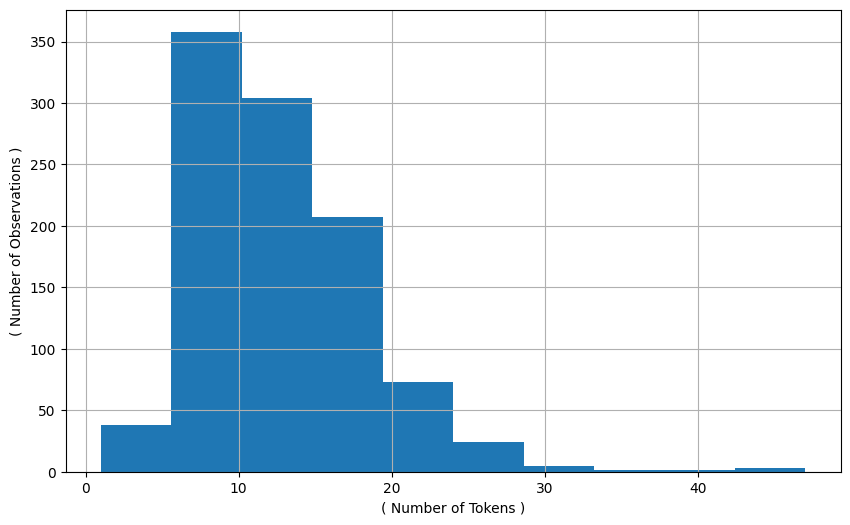

In [12]:
# Plotting histogram for number of tokens in English sentences
plot_seq_length(data.english)

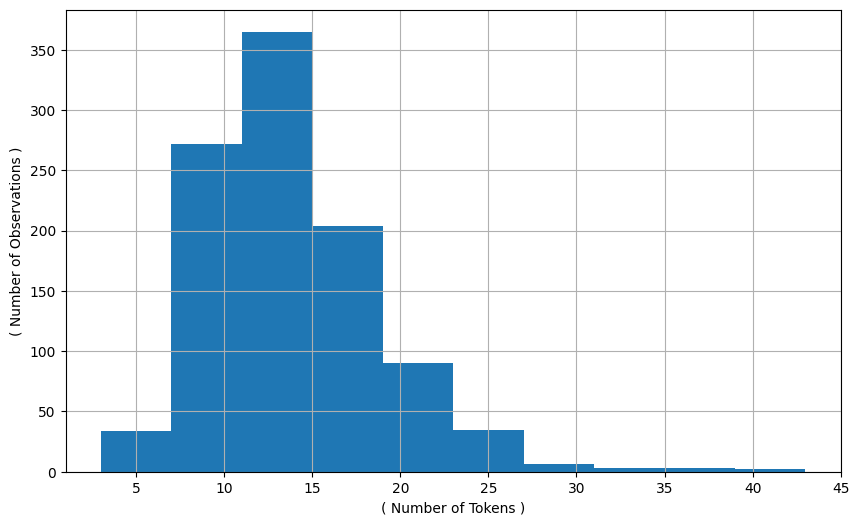

In [13]:
# Plotting histogram for number of tokens in Italian sentences
plot_seq_length(data.jawa)

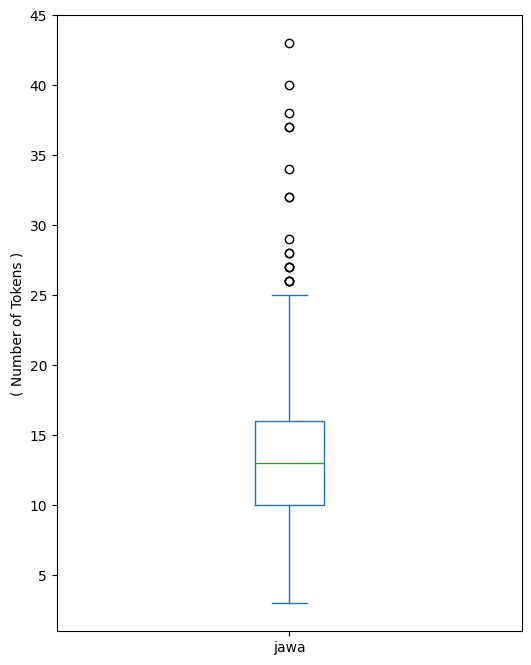

In [14]:
# Plotting boxplot for number of tokens in English sentences
plot_seq_length(data.jawa, kind="box")

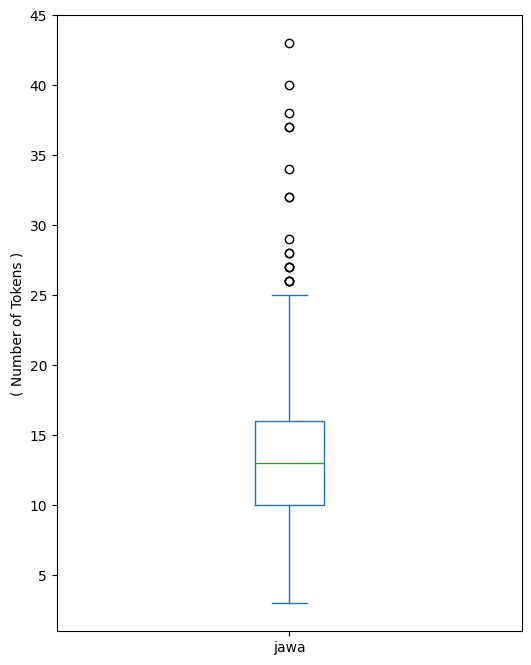

In [15]:
# Plotting boxplot for number of tokens in Italian sentences
plot_seq_length(data.jawa, kind="box")

*So, we can clearly see that the sequence length is around 10-12 on average.*

# **Fitting tokenizer and defining preprocessing functions :**

In [16]:
# Instantiating and fitting the Tokenizer on english text
eng_tokenizer_train_data = data["english"]
eng_tok = Tokenizer(oov_token="UNK")
eng_tok.fit_on_texts(eng_tokenizer_train_data.values)

# Instantiating and fitting the Tokenizer on italian text
it_tokenizer_train_data = data["jawa"]
it_tok = Tokenizer(oov_token="UNK")
it_tok.fit_on_texts(it_tokenizer_train_data.values)

In [17]:
def sent_to_seq(sequences, tokenizer, vocab_size=None, reverse=False, onehot=False):

    """ Converts text data into sequences supported by model input layers.

    Args:
        sequences (list): List of text data.
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tensorflow tokenizer object.
        vocab_size (int): Number of words in the whole vocabulary.
        reverse (bool): Reverses the padded sequence if set True. Defaults False.
                        (Eg: if set True, [1 2 3 0 0] becomes [0 0 3 2 1])
        onehot (bool): Creates onehot representation of the padded sequence if set True.
                       Defaults False.

    Returns:
        preprocessed_seq (list): List of preprocessed sequences.

    """

    # Tokenizing
    seq = tokenizer.texts_to_sequences(sequences)

    # Padding
    preprocessed_seq = pad_sequences(seq, padding='post', truncating='post', maxlen=20)

    # Reversing
    if reverse:
        preprocessed_seq = preprocessed_seq[:, ::-1]

    # Onehot encoding
    if onehot:
        preprocessed_seq = to_categorical(preprocessed_seq, num_classes=vocab_size)

    return preprocessed_seq


In [18]:
def generate_batch(X, y, batch_size):

    """ Generator function to preprocess the data in batches and
        feed them to the model.

    Args:
        X (list): List of text data.
        y (list): List of text data.
        batch_size (int): Number of items to be preprocessed and fed
                          in a single batch.
    Yields:
        en_x (list): Preprocessed data supported by encoder input layer.
        de_x (list): Preprocessed data supported by decoder input layer.
                    (1 timestep behind de_y, since
                     TimeDistributed layer is being used for training)
        de_y (list): Preprocessed actual outputs of decoder.
                     (1 timestep ahead of de_x, since
                     TimeDistributed layer is being used for training)
    """

    while True:
        for batch in range(0, len(X), batch_size):
            en_x = sent_to_seq(X[batch: batch+batch_size],
                               tokenizer = eng_tok,
                               vocab_size = eng_vocab_size,
                               onehot = True,
                               reverse = True)

            de_xy = sent_to_seq(y[batch: batch+batch_size],
                                tokenizer = it_tok,
                                vocab_size = it_vocab_size,
                                onehot = True)

            de_x = de_xy[:,:-1,:]
            de_y = de_xy[:,1:,:]

            yield([en_x, de_x], de_y)

**What if we don't generate batches?** BOOM!! Resource will get exhausted in a fraction of seconds. Adding some simple math, We have 200K+ training sequences and each have a length of 20 after padding. Our vocabulary size is 13893 for english and 28445 for italian text. When we do padding and then onehot encoding for all data at the same time, It becomes a huge array of dimension "sequence length(20) x number of samples(200k+) x vocab size(28k+)". That's why we preprocess and feed data in batches.

# **Defining Model Architecture :**

In [19]:
eng_seq_len = 20    # First dimension of encoder Input shape
eng_vocab_size = len(eng_tok.word_index)+1    # Second dimension of encoder Input shape
gru_units = 2048    # Number of GRU units

In [20]:
# Encoder
en_inputs = Input(shape=(eng_seq_len, eng_vocab_size))
en_gru = GRU(gru_units, return_state=True)
en_out, en_state = en_gru(en_inputs)

In [21]:
it_seq_len = 20     # First dimension of decoder Input shape
it_vocab_size = len(it_tok.word_index)+1     # Second dimension of decoder Input shape

In [22]:
# Decoder
de_inputs = Input(shape=(it_seq_len-1, it_vocab_size))
de_gru = GRU(gru_units, return_sequences=True)
de_out = de_gru(de_inputs, initial_state=en_state)

In [23]:
# Decoder output architecture
# TimeDistributed layer is used for training purpose
de_dense = TimeDistributed(Dense(it_vocab_size, activation='softmax'))
de_pred = de_dense(de_out)

# **Why TimeDistributed layer is being used and what is teacher forcing?**
<br></br>
We are developing NMT model with **teacher forcing algorithm**. So, What is teacher forcing? Normally we will use a repeat vector layer to repeat the context vector provided by the encoder as input to decoder at each timestep. Instead, In teacher forcing algorithm, we will be supplying the ouput of the decoder at previous time step as input to the decoder at current time step. Same applies for the context vector. Hence achieving better results.  
<br></br>
**Time Distributed** layer is being used for training purpose. We will not be using this layer in inference model. The layer takes the whole inputs and feeds the vectors and compares results one by one for each time step.

In [24]:
# Compiling
nmt = Model(inputs=[en_inputs, de_inputs], outputs=de_pred)
nmt.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc"])

In [25]:
print(nmt.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 2026)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 19, 2172)]           0         []                            
                                                                                                  
 gru (GRU)                   [(None, 2048),               2504294   ['input_1[0][0]']             
                              (None, 2048)]               4                                       
                                                                                                  
 gru_1 (GRU)                 (None, 19, 2048)             2593996   ['input_2[0][0]',         

# **Training, Evaluating and plotting results :**

In [26]:
def plot_history(history, metric = "loss"):

    """ Plots training history of models.

    Args:
        history (History): Tensorflow History object containing training
                           history of the model.
        metric (str): 'accuracy' or 'loss'. Metric to be plotted.

    Returns:
        Nothing

    """

    history_dict = history.history
    epochs = range(1, len(history_dict['loss'])+1)

    if metric == "loss":
        train_loss = history_dict['loss']    # Training loss over epochs
        val_loss = history_dict['val_loss']    # Validation loss over epochs
        plt.plot(epochs, train_loss,'b', label='Training error')
        plt.plot(epochs, val_loss,'b', color="orange", label='Validation error')
        plt.title('Training and Validation error')
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()
        plt.show()

    elif metric == "accuracy":
        train_acc = history_dict['acc']    # Training accuracy over epochs
        val_acc = history_dict['val_acc']    # Validation accuracy over epochs
        plt.plot(epochs, train_acc,'b', label='Training accuracy')
        plt.plot(epochs, val_acc,'b', color="orange", label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()



In [27]:
n_epochs, batch_size = 30, 100 # multiply by two

In [28]:
class TresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(TresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [29]:
# Training and validation
trainingCallback = TresholdCallback(threshold=0.95)
history = nmt.fit(generate_batch(eng_train, it_train, batch_size=batch_size),
                  steps_per_epoch = len(eng_train)//batch_size,
                  epochs = n_epochs,
                  validation_data = generate_batch(eng_val, it_val, batch_size=batch_size),
                  validation_steps = len(eng_val)//batch_size,
                  callbacks=[trainingCallback])

Epoch 1/30
6/6 [==============================] - 33s 5s/step - loss: 6.7059 - acc: 0.3099 - val_loss: 6.9751 - val_acc: 0.3945
Epoch 2/30
6/6 [==============================] - 24s 5s/step - loss: 5.9263 - acc: 0.3828 - val_loss: 4.7399 - val_acc: 0.3797
Epoch 3/30
6/6 [==============================] - 24s 4s/step - loss: 4.7074 - acc: 0.3895 - val_loss: 4.4272 - val_acc: 0.4037
Epoch 4/30
6/6 [==============================] - 26s 4s/step - loss: 4.4144 - acc: 0.3776 - val_loss: 4.4309 - val_acc: 0.3903
Epoch 5/30
6/6 [==============================] - 24s 4s/step - loss: 4.2621 - acc: 0.3717 - val_loss: 4.5604 - val_acc: 0.3843
Epoch 6/30
6/6 [==============================] - 24s 4s/step - loss: 4.1570 - acc: 0.3805 - val_loss: 4.1988 - val_acc: 0.4088
Epoch 7/30
6/6 [==============================] - 26s 4s/step - loss: 4.0177 - acc: 0.3896 - val_loss: 4.1760 - val_acc: 0.4042
Epoch 8/30
6/6 [==============================] - 27s 5s/step - loss: 3.8692 - acc: 0.3968 - val_loss: 4

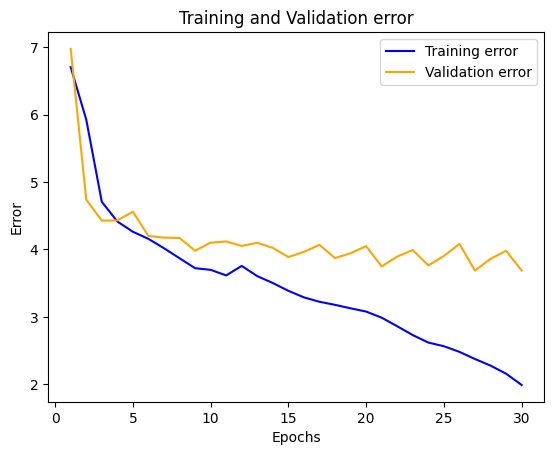

In [30]:
plot_history(history)

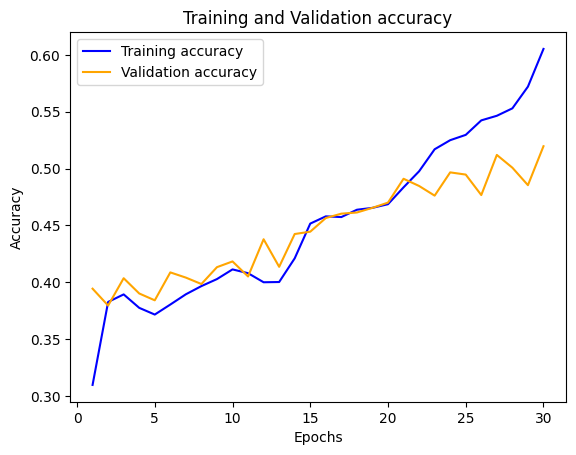

In [31]:
plot_history(history, metric="accuracy")

In [32]:
# Evaluating on completely unseen data
results = nmt.evaluate(generate_batch(eng_test, it_test, batch_size=batch_size), steps=batch_size)
print(f"========== Test set loss: {results[0]} - Test set Accuracy: {results[1]*100} % ==========")

100/100 [==============================] - 134s 1s/step - loss: 4.2992 - acc: 0.4651
========== Test set loss: 4.299198627471924 - Test set Accuracy: 46.51303291320801 % ==========


# **Copying trained layers' weights :**

In [33]:
en_gru_weights = en_gru.get_weights()   # Encoder GRU layer weights
de_gru_weights = de_gru.get_weights()    # Decoder GRU layer weights
de_dense_weights = de_dense.get_weights()    # Decoder Dense layer weights

# **Defining inference model Architecture :**

In [34]:
# Encoder
en_inputs = Input(shape=(eng_seq_len, eng_vocab_size))
en_gru = GRU(gru_units, return_state=True)
en_out, en_state = en_gru(en_inputs)

encoder = Model(inputs=en_inputs, outputs=en_state)

In [35]:
# Assigns weights of trained model layer to inference model layer
en_gru.set_weights(en_gru_weights)

In [36]:
# Decoder
de_inputs = Input(shape=(1, it_vocab_size))

# Following layer is added in inference model
# to take context vector as input
de_state_in = Input(shape=(gru_units,))

de_gru = GRU(gru_units, return_state=True)
de_out, de_state_out = de_gru(de_inputs, initial_state=de_state_in)

# TimeDistributed layer is not used since
# we will be using .predict() method for
# each timestep manually
de_dense = Dense(it_vocab_size, activation='softmax')
de_pred = de_dense(de_out)

decoder = Model(inputs=[de_inputs, de_state_in], outputs=[de_pred, de_state_out])

In [37]:
# Assigns weights of trained model layers to inference model layers
de_gru.set_weights(de_gru_weights)
de_dense.set_weights(de_dense_weights)

In [38]:
print(decoder.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1, 2172)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 gru_3 (GRU)                 [(None, 2048),               2593996   ['input_4[0][0]',             
                              (None, 2048)]               8          'input_5[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2172)                 4450428   ['gru_3[0][0]']         

# **Translation in action :**

In [39]:
def word_to_onehot(tokenizer, word, vocab_size):

    """ Converts a single word into onehot representation.

    Args:
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tensorflow tokenizer object.
        word (str): Word to be tokenized and onehot encoded.
        vocab_size (int): Number of words in the whole vocabulary.

    Returns:
        de_onhot (list): Onehot representation of given word.

    """

    de_seq = tokenizer.texts_to_sequences([[word]])
    de_onehot = to_categorical(de_seq, num_classes=vocab_size).reshape(1, 1, vocab_size)

    return de_onehot


def translate(eng_sentence):

    """ Returns Italian translation of given english sentence.

    Args:
        eng_sentence (str): English text to be translated.

    Returns:
        it_sent (str): Italian translated text.

    """

    en_seq = sent_to_seq([eng_sentence],
                         tokenizer=eng_tok,
                         reverse=True,
                         onehot=True,
                         vocab_size=eng_vocab_size)

    en_st = encoder.predict(en_seq)
    de_seq = word_to_onehot(it_tok, "sos", it_vocab_size)
    it_sent = ""
    for i in range(it_seq_len):
        de_prob, en_st = decoder.predict([de_seq, en_st])
        index = np.argmax(de_prob[0, :], axis=-1)
        de_w = it_tok.index_word[index]
        de_seq = word_to_onehot(it_tok, de_w, it_vocab_size)
        if de_w == 'eos': break
        it_sent += de_w + ' '

    return it_sent

In [40]:
for sent in eng_test[: 25]:
    print(f"English: {sent}")
    print(f"Translated text: {translate(sent)}")

English: Rooms at the Suna Hotel are equipped with a private balcony facing the Hotel Park.
1/1 [==============================] - 0s 22ms/step
Translated text: ing hotel iki nyedhiyakake layanan antar jemput bandara kanggo tamu 


NameError: name 'extractKeyword' is not defined

# **Saving Tokenizers :**

In [ ]:
# English
eng_tok_file = open("English Tokenizer.pkl", "wb")
pickle.dump(eng_tok, eng_tok_file)

# Italian
it_tok_file = open("Italian Tokenizer.pkl", "wb")
pickle.dump(it_tok, it_tok_file)

# **Saving NMT components :**

In [ ]:
# Encoder
save_model(encoder, "./encoder")

# Decoder
save_model(decoder, "./decoder")

# **Information Extraction**

In [ ]:
def extractKeyword(text):
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 1
    kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, 
                                         dedupFunc=deduplication_algo, windowsSize=windowSize, 
                                         top=numOfKeywords)                   
    keywords = kw_extractor.extract_keywords(text)
    return keywords[0]

def googleSearch(keyword):
    url = 'https://www.google.com/search'
    headers = {
    	'Accept' : '*/*',
    	'Accept-Language': 'en-US,en;q=0.5',
    	'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82',
    }
    parameters = {'q': keyword}
    content = requests.get(url, headers = headers, params = parameters).text
    soup = bs4.BeautifulSoup(content, 'html.parser')
    search = soup.find(id = 'search')
    first_link = search.find('a')
    return first_link['href']

# **Output**

In [ ]:
# The Grand Dafam Syariah Hotel is very clean
# Aston Banua Hotel is one of the best hotels in Banjarmasin
# Student Park Hotel is a cozy hotel located in Yogyakarta

text_to_translate = "Aston Banua Hotel is one of the best hotels in Banjarmasin" # Change this, and run this cell
keyword = extractKeyword(text_to_translate)
keyword = keyword[0]
print(f"English: {text_to_translate}")
print(f"Translated text: {translate(text_to_translate)}")
print(f"Keyword: {keyword}")

search_result = googleSearch(keyword)

print(f"Referensi: {search_result}")